In [1]:
from kernel_submission_2 import *

/home/minnie/.pyenv/versions/3.6.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/minnie/.pyenv/versions/3.6.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/minnie/.ve/poverty-prediction/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
train_df = load_train_data()

In [7]:
df = train_df.loc[train_df[target_column].isin([1,3])]
hh_level = compress_to_household_level(train_df)

/home/minnie/.ve/poverty-prediction/lib/python3.6/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


In [8]:
no_males = pd.DataFrame(train_df.groupby(household_id)['male'].sum()).rename(columns={'male':'no_males'})
hh_level['no_males'] = (no_males['no_males']==0).astype(int)

In [9]:
hh_level['male_education'] = train_df[train_df['male']==1].groupby(household_id)['education-level'].mean()
hh_level['male_education'] = hh_level['male_education'].fillna(0)
hh_level['male_education'] = normalize_column(hh_level, 'male_education')

In [10]:
hh_level['mean_education_level'] = train_df.groupby(household_id)['education-level'].mean()
hh_level['mean_education_level'] = normalize_column(hh_level, 'mean_education_level')
hh_level['sum_education_level'] = train_df.groupby(household_id)['education-level'].sum()
hh_level['sum_education_level'] = normalize_column(hh_level, 'sum_education_level')

/home/minnie/.ve/poverty-prediction/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [11]:
data = get_balanced_data(hh_level, 123)
X = data.drop(target_column, axis=1)
y = data[target_column]

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 10
plt.rcParams['patch.edgecolor'] = 'k'

Feature ranking:
1. mean_education_level (0.023220)
2. male_education (0.022372)
3. education-level (0.022046)
4. working_age_educ (0.018319)
5. edjefe (0.016941)
6. edjef (0.016377)
7. meaneduc (0.016278)
8. dependency (0.016050)
9. building-material-quality (0.015867)
10. building-score (0.015756)


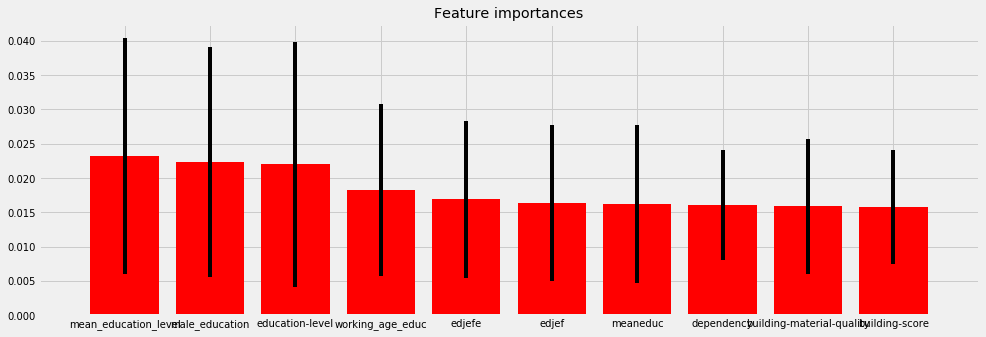

In [13]:
from sklearn.ensemble import ExtraTreesClassifier

# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1][:10]
features = [X.columns[f] for f in indices]

print("Feature ranking:")
for f in range(len(indices)):
    print("%d. %s (%f)" % (f + 1, features[f], importances[indices[f]]))

plt.figure(figsize=(15, 5))
plt.title("Feature importances")

bar_offsets = (np.arange(len(indices)))
plt.bar(bar_offsets, height=importances[indices], width=0.8,
       color="r", yerr=std[indices], align="center")
plt.xticks(bar_offsets, features)
plt.xlim([-1, len(indices)])
plt.show()

In [ ]:
is_1 = data[data[target_column]==1]
is_2 = data[data[target_column]==2]
is_3 = data[data[target_column]==3]
is_4 = data[data[target_column]==4]
sns.distplot(is_1['education-level']*is_1['r4h2'], hist=False, rug=True, label='1')
sns.distplot(is_2['education-level']*is_2['r4h2'], hist=False, rug=True, label='2')
sns.distplot(is_3['education-level']*is_3['r4h2'], hist=False, rug=True, label='3')
sns.distplot(is_4['education-level']*is_4['r4h2'], hist=False, rug=True, label='4')
plt.legend()

In [ ]:
sns.distplot(is_2['building-materials'], hist=False, rug=True, label='2')
sns.distplot(is_3['building-materials'], hist=False, rug=True, label='3')
plt.legend()

In [ ]:
sns.distplot(is_2['meaneduc'], hist=False, rug=True, label='2')
sns.distplot(is_3['meaneduc'], hist=False, rug=True, label='3')
plt.legend()

In [ ]:
from column_categories import column_descriptions

print(column_descriptions.get('edjefe'))
print(column_descriptions.get('meaneduc'))
print(column_descriptions.get('dependency'))
print(column_descriptions.get('escolari'))

Education is an important signal - let's try to get a clearer signal

At the moment `education-level` is the mode of education levels of all individuals whose records we have for that household.

What if we also took the sum of all adults (individuals of working age).

We have the following indications of value of work (age, gender, education):

Household-level:
    - 'hogar_nin':'Number of children 0 to 19 in household'
    - 'hogar_adul':'Number of adults in household'
    - 'hogar_mayor':'# of individuals 65+ in the household'
    - 'hogar_total':'# of total individuals in the household'
    - 'r4h1':'Males younger than 12 years of age'
    - 'r4h2':'Males 12 years of age and older'
    - 'r4h3':'Total males in the household'
    - 'r4m1':'Females younger than 12 years of age'
    - 'r4m2':'Females 12 years of age and older'
    - 'r4m3':'Total females in the household'
    - 'r4t1':'persons younger than 12 years of age'
    - 'r4t2':'persons 12 years of age and older'
    - 'r4t3':'Total persons in the household'
    - 'tamhog':'size of the household'
    - 'tamviv':'number of persons living in the household'
    - 'hhsize':'household size'
    - 'edjefe':'years of education of male head of household, (escolari + head of household + gender)'
    - 'edjefa':'years of education of female head of household, (escolari + head of household + gender)'
    - 'edjef':'years of education of head of household, (escolari + head of household)'
    - 'meaneduc':'average years of education for adults (18+)'
    
Individual-level:
    - 'dis':'=1 if disable person'
    - 'male':'=1 if male'
    - 'female':'=1 if female'
    - 'age':'Age in years'
    - 'education-level':'value representing how far through school they are'
    - 'escolari':'years of schooling',
    - 'rez_esc':'Years behind in school'

In [ ]:
df = train_df[train_df['age']>=18][[household_id,'escolari','meaneduc']].groupby(household_id).mean().round(2)
inconsistent = df[df['escolari']!=df['meaneduc']].reset_index()[household_id]

In [ ]:
train_df[train_df[household_id].isin(inconsistent)].sort_values(household_id)[[household_id,'escolari','meaneduc', target_column]]

### Investigating potential outlier

Household `03f4e5f4d` has high education but extreme poverty - what's the deal?
  - `v2a1` is none or missing (no monthly rent payment)
  - `hacdor` is 0 - is a boolean value, represents overcrowding, `hacapo` is 0 - boolean value represents overcrowding
  - `overcrowding` is 1 - represents # persons per room
  - `rooms` there are 5 rooms, 3 are bedrooms
  - `tamhog` etc is 3 - all three people have individual records
  - `v14a` they have a bathroom
  - `refrig` they have a fridge
  - `v18q1` they have no tablets
  - `r4t` all 3 are adults
  - 2 females one male, none disabled
  - 2 completed secondary school, one (female) only completed primary
  - the female with least education is considered head of household, she is 58, the others are 23f, and 19m
  - the head of household is divorced, the two younger individuals are single and her son and daughter

In [ ]:
# ['tamhog','tamviv','hhsize','hogar_total']
hh = train_df[train_df[household_id]=='03f4e5f4d']
hh

In [ ]:
pd.options.display.max_seq_items
pd.options.display.max_seq_items = 150

In [ ]:
normalize_column(train_df,'education-level',force_reset=True).get('03f4e5f4d')

The (adult) children have above average education

In [ ]:
hh_level = hh_level.reset_index()

In [ ]:
my_hh = hh_level[hh_level[household_id]=='03f4e5f4d']
my_hh

In [ ]:
my_hh[['cielorazo','building-quality', 'building-materials',
       'building-material-quality', 'building-warning', 'less-than-3-rooms',
       'sanitation', 'building-score','v14a']]

In [ ]:
my_hh[['handheld-tech', 'comforts', 'tech', 'tablets-pp', 'computer', 'television','qmobilephone']]

In [ ]:
my_hh[['v2a1','house-ownership']]

### Another outlier?

In [ ]:
hh = train_df[train_df[household_id]=='fd8cd9fa1']
hh[['tamhog','tamviv','hhsize','hogar_total',target_column]]

- There are 5 members of the household and we have records for all of them
- Head of household is 62m with incomplete primary school education, her married to 54f with incomplete primary
- There is one son, 23m with incomplete secondary education
- Single brother 64m, with incomplete primary
- Single 19m with incomplete secondary education "other family member"
- They live in a high quality building

In [ ]:
# 'parentesco1','parentesco2','parentesco3','parentesco4','parentesco5','parentesco6','parentesco7','parentesco8','parentesco9','parentesco10','parentesco11','parentesco12'
# 'estadocivil1','estadocivil2','estadocivil3','estadocivil4','estadocivil5','estadocivil6','estadocivil7'
hh[[head_of_household,'male','age','education-level']]

In [ ]:
my_hh = hh_level[hh_level[household_id]=='fd8cd9fa1']

In [ ]:
my_hh[['cielorazo','building-quality', 'building-materials',
       'building-material-quality', 'building-warning', 'less-than-3-rooms',
       'sanitation', 'building-score','v14a']]

In [ ]:
my_hh[['handheld-tech', 'comforts', 'tech', 'tablets-pp', 'computer', 'television','qmobilephone']]